In [1]:
import jax
import jax.numpy as jnp 
import matplotlib.pyplot as plt
import jax.random as jr
from IPython.display import Markdown
jax.config.update("jax_enable_x64", True)
plt.rcdefaults() # restore default settings
plt.rcParams.update({
    "text.usetex": True,
    "font.size": plt.rcParams["font.size"] * 1.5,
    "lines.linewidth": 3,

})
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rc('text.latex', preamble=r'\usepackage{bm}')
import time

### Functions for testing BFGS

In [2]:
def f1(x):
    """
    Adjiman Function
    """
    return (jnp.cos(x[0]) * jnp.sin(x[1])) - (x[0] / (x[1] ** 2 + 1))


def f2(x):
    """
    Rosenbrock N-D
    """
    return jnp.sum(100 * (x[1:] - x[:-1]) ** 2 + (x[:-1] - 1) ** 2)


def f3(x):
    """
    Paviani Function
    """
    return jnp.sum(jnp.log(x - 2) ** 2 + jnp.log(10 - x) ** 2) - jnp.prod(x) ** (0.2)


def f4(x):
    """
    Csendes Function
    """
    return jnp.sum(x**6 * (2 + jnp.sin(1.0 / x)))


def f5(x):
    """
    Griewank Function
    """
    return (
        jnp.sum(x**2)
        - jnp.prod(jnp.cos(2 * jnp.pi * x / jnp.sqrt(jnp.arange(1, x.shape[0] + 1))))
        + 1
    )


def f6(x):
    """
    Hosaki Function
    """
    return (
        (1 - 8 * x[0] + 7 * x[0] ** 2 - (7 / (3 * x[0] ** 2)) + (1 / (4 * x[0] ** 4)))
        * x[1] ** 2
        * jnp.exp(-x[1])
    )


def f7(x):
    """
    Brent Function
    """
    return (x[0] + 10) ** 2 + (x[1] + 10) ** 2 + jnp.exp(-x[0] ** 2 - x[1] ** 2)


def f8(x):
    """
    Giunta Function
    """
    return 0.6 + jnp.sum(
        jnp.sin((16.0 / 15.0) * x - 1)
        + jnp.sin((16.0 / 15.0) * x - 1) ** 2
        + jnp.sin(4 * ((16.0 / 15.0) * x - 1))
    )


def f9(x):
    """
    Styblinski-Tang Function
    """
    return 0.5 * jnp.sum(x**4 - 16 * x**2 + 5 * x)


def f10(x):
    """
    Trid 6 Function
    """
    return jnp.sum((x - 1) ** 2) - jnp.sum(x[1:] * x[:-1])


def f11(x):
    """
    Trefethen Function
    """
    return (
        jnp.exp(jnp.sin(50 * x[0]))
        + jnp.sin(60 * jnp.exp(x[1]))
        + jnp.sin(70 * jnp.sin(x[0]))
        + jnp.sin(jnp.sin(80 * x[1]))
        - jnp.sin(10 * (x[0] + x[1]))
        + 0.25 * (x[0] ** 2 + x[1] ** 2)
    )


def f12(x):
    """
    Ursem 1 Function
    """
    return -jnp.sin(2 * x[0] - 0.5 * jnp.pi) - 3 * jnp.cos(x[1]) - 0.5 * x[0]


def f13(x):
    """
    Wolfe Function
    """
    return (4.0 / 3) * (x[0] ** 2 + x[1] ** 2 - x[0] * x[1]) ** (0.75) + x[2]


In [3]:

def backtracking_line_search(phi, phi_0, grad_phi_0, a_max, rho=0.8, c=9e-1):
    """
    Simple backtracking line search using the Armijo condition.

    phi: objective function.
    x: current point.
    p: search direction.
    grad_x: gradient at x.
    alpha: initial step size.
    rho: factor to decrease alpha.
    c: Armijo constant.
    """
    a = a_max
    while phi(a) > phi_0 + c * a * grad_phi_0:
        a *= rho
    return a


def line_search(
    phi,
    phi_0,
    grad_phi_0,
    a_max,
    zoom_method="strong_wolfe",
    c1=1e-4,
    c2=9e-1,
    max_iter=100,
):
    a = a_max / 2.0
    a_prev = 0.0
    i = 0
    phi_curr = phi_0
    zoom = None
    if zoom_method == "strong_wolfe":
        zoom = lambda al, au: interpolation_line_search(
            phi, phi_0, grad_phi_0, al, au, c1=c1, c2=c2, max_iter=10
        )
    elif zoom_method == "armijo":
        return backtracking_line_search(
            phi, phi_0, grad_phi_0, a_max=a_max, rho=0.5, c=c2
        )
    else:
        raise ValueError("Zoom method not implemented")

    while i < max_iter:
        phi_prev = phi_curr
        phi_curr = phi(a)
        if phi_curr > phi_0 + c1 * a * grad_phi_0 or (phi_curr >= phi_prev and i > 0):
            return zoom(a_prev, a)
        grad_phi_curr = jax.grad(phi)(a)
        if jnp.abs(grad_phi_curr) <= -1 * c2 * grad_phi_0:
            return a
        if grad_phi_curr >= 0:
            return zoom(a_prev, a)
        a_prev = a
        a = (a + a_max) / 2.0
        i += 1
    print("Line Search Failed")
    return 0.0


def gradient_descent(f, x0, lr=0.001, max_iter=1000, tol=1e-15):
    """
    Gradient descent optimization

    f: function to minimize.
    x0: initial point as a JAX array.
    max_iter: maximum iterations.
    tol: tolerance for stopping criterion (based on gradient norm).
    """
    # Current point and dimension.
    x = x0
    n = x0.shape[0]
    # Function to compute the gradient using automatic differentiation.
    grad_f = jax.grad(f)
    xs = [x0]
    i = 0
    g = grad_f(x0)
    while jnp.linalg.norm(g) > tol and i < max_iter:
        s = -lr * g
        x_new = x + s
        # Move to the next point.
        x = x_new
        xs.append(x)
        g = grad_f(x)
        i += 1
    if i == max_iter:
        print("Max iterations reached")
    return x, jnp.array(xs)


def steepest_descent(f, x0, max_iter=1000, line_search_max_iter=20, tol=1e-15):
    """
    Steepest descent optimization.

    f: function to minimize.
    x0: initial point as a JAX array.
    max_iter: maximum iterations.
    tol: tolerance for stopping criterion (based on gradient norm).
    """
    # Current point and dimension.
    x = x0
    n = x0.shape[0]
    # Function to compute the gradient using automatic differentiation.
    grad_f = jax.grad(f)
    xs = [x0]
    i = 0
    g = grad_f(x0)
    while jnp.linalg.norm(g) > tol and i < max_iter:
        # Compute the line search direction.
        p = -g
        # Perform a line search to determine step size.
        phi = lambda alpha: f(x + alpha * p)
        grad_phi_0 = jnp.dot(g, p)
        alpha = line_search(
            phi, phi(0.0), grad_phi_0, 1.0, max_iter=line_search_max_iter
        )
        # Update step.
        s = alpha * p
        x_new = x + s
        # Move to the next point.
        x = x_new
        xs.append(x)
        g = grad_f(x)
        i += 1

    if i == max_iter:
        print("Max iterations reached")
    return x, jnp.array(xs)


def interpolation_line_search(
    phi, phi_0, grad_phi_0, al, au, c1=1e-4, c2=9e-1, max_iter=30
):
    i = 0
    a = al
    a_prev = 0.0
    while i < max_iter:
        if jnp.abs(al) <= 1e-14:
            a = (-grad_phi_0 * au**2) / (2.0 * (phi(au) - phi_0 - au * grad_phi_0))
        else:
            if jnp.linalg.norm(au - al) < 1e-14:
                a = (al + au) / 2.0
            else:
                coeff = (1.0 / (al**2 * au**2 * (au - al))) * (
                    jnp.array([[al**2, -(au**2)], [-(al**3), au**3]])
                    @ jnp.array(
                        [
                            phi(au) - phi_0 - au * grad_phi_0,
                            phi(al) - phi_0 - al * grad_phi_0,
                        ]
                    )
                )
                a_poly, b_poly = coeff[0], coeff[1]
                if jnp.abs(a_poly) < 1e-14 or (
                    (b_poly**2 - 3 * a_poly * grad_phi_0) < 0
                ):
                    a = (al + au) / 2.0
                else:
                    a = (-b_poly + jnp.sqrt(b_poly**2 - 3 * a_poly * grad_phi_0)) / (
                        3 * a_poly
                    )
        if jnp.abs(a - a_prev) < 1e-10:
            a = a_prev / 2.0
        curr_phi = phi(a)
        if curr_phi > phi_0 + c1 * a * grad_phi_0 or (curr_phi >= phi(al) and i > 0):
            au = a
        else:
            grad_phi_curr = jax.grad(phi)(a)
            if jnp.abs(grad_phi_curr) <= -1.0 * c2 * grad_phi_0:
                return a
            if grad_phi_curr * (au - al) >= 0:
                au = al
            al = a
        i += 1
    return al


### Newton Implementation

In [4]:
def newton(f, x0, max_iter=100, tol=1e-15):
    """
    Newton's method for optimization.
    """
    x = x0
    n = x0.shape[0]
    grad_f = jax.grad(f)
    hess_f = jax.hessian(f)
    xs = [x0]
    i = 0
    r = jnp.inf
    g = grad_f(x0)

    while jnp.linalg.norm(g) > tol and i < max_iter:

        # Compute the search direction.
        p = -jnp.linalg.solve(hess_f(x), g)
        # Perform a line search to determine step size.
        phi = lambda alpha: f(x + alpha * p)
        grad_phi_0 = jnp.dot(g, p)
        alpha = backtracking_line_search(phi, phi(0.0), grad_phi_0, 1.0)
        # Update step.
        s = alpha * p
        x_new = x + s
        r = f(x) - f(x_new)
        # Move to the next point.
        x = x_new
        xs.append(x)
        g = grad_f(x)
        i += 1
    if i == max_iter:
        print("Max iterations reached")

    return x, jnp.array(xs)



### BFGS Implementation

In [5]:
def bfgs(
    f, x0, zoom_method="strong_wolfe", max_iter=100, line_search_max_iter=100, tol=1e-15
):
    """
    BFGS optimization.

    f: function to minimize.
    x0: initial point as a JAX array.
    max_iter: maximum iterations.
    tol: tolerance for stopping criterion (based on gradient norm).
    """
    # Current point and dimension.
    x = x0
    n = x0.shape[0]
    # Initialize the inverse Hessian approximation as the identity matrix.
    Hinv = jnp.eye(n)
    # Function to compute the gradient using automatic differentiation.
    grad_f = jax.grad(f)
    xs = [x0]
    i = 0
    r = jnp.inf
    g = grad_f(x0)
    while jnp.linalg.norm(g) > tol and i < max_iter:

        # Compute the search direction.
        p = -Hinv @ g
        # Perform a line search to determine step size.
        phi = lambda alpha: f(x + alpha * p)
        grad_phi_0 = jnp.dot(g, p)
        alpha = line_search(phi, phi(0.0), grad_phi_0, 1.0, zoom_method=zoom_method)
        # Update step.
        s = alpha * p
        x_new = x + s
        y = grad_f(x_new) - g
        # Compute scaling factor.
        rho = jnp.dot(y, s)
        rho = 1.0 / rho
        # BFGS Hessian update.
        # Hinv = (
        #     Hinv
        #     + ((jnp.dot(s, y) + y.T @ (Hinv @ y)) * (jnp.outer(s, s)))
        #     / (jnp.dot(s, y) ** 2)
        #     - (jnp.outer(Hinv @ y, s) + jnp.outer(s, jnp.dot(y.T, Hinv)))
        #     / (jnp.dot(s, y))
        # )
        Hinv = Hinv - rho * (
            jnp.outer(Hinv @ y, s)
            + jnp.outer(s, jnp.dot(y.T, Hinv))
            - (jnp.outer(s, s) * (1 + rho * (y.T @ Hinv @ y)))
        )

        # Move to the next point.
        r = f(x) - f(x_new)
        if zoom_method == "strong_wolfe" and jnp.abs(r) < tol:
            break

        x = x_new
        xs.append(x)
        g = grad_f(x)
        i += 1
    if i == max_iter:
        print("Max iterations reached")
    return x, jnp.array(xs)



### Gradient Descent on x^2

### Rosenbrock Function
$$
f_{Rosenbrock}(x_1,x_2) = 100*(x_2 - x_1^2)^2 + (1-x_1)^2
$$

In [6]:
def rosenbrock(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

### Contour plot of convergence of BFGS on RosenBrock Function

BFGS:  [1. 1.]
Newton:  [1. 1.]


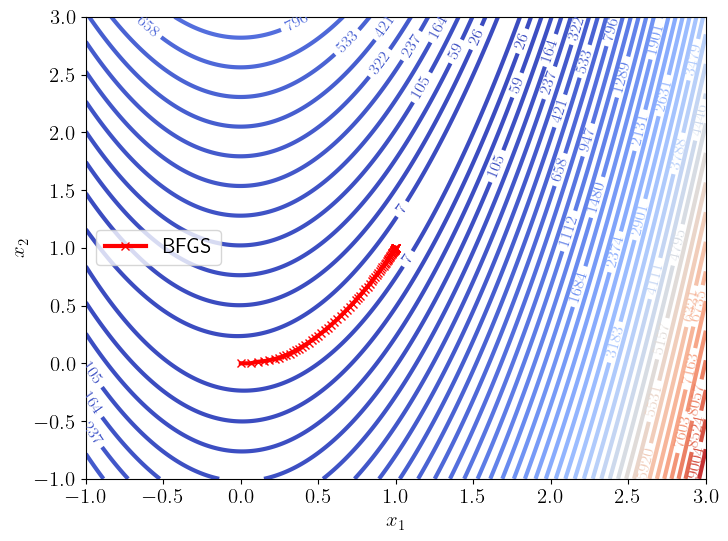

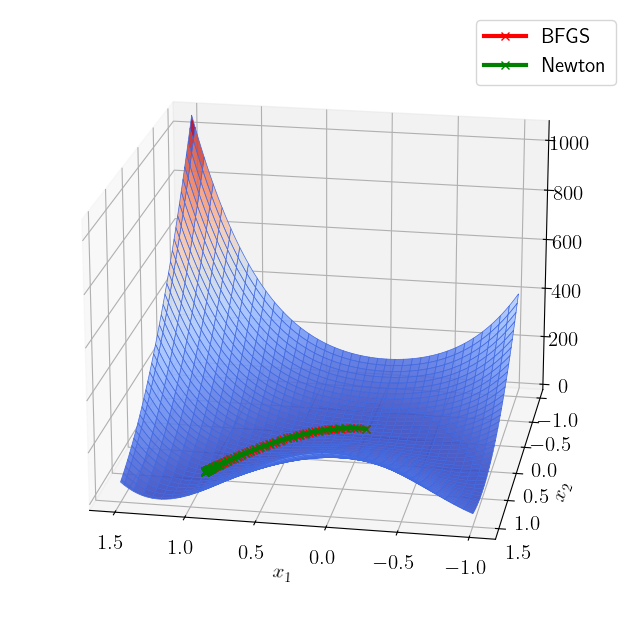

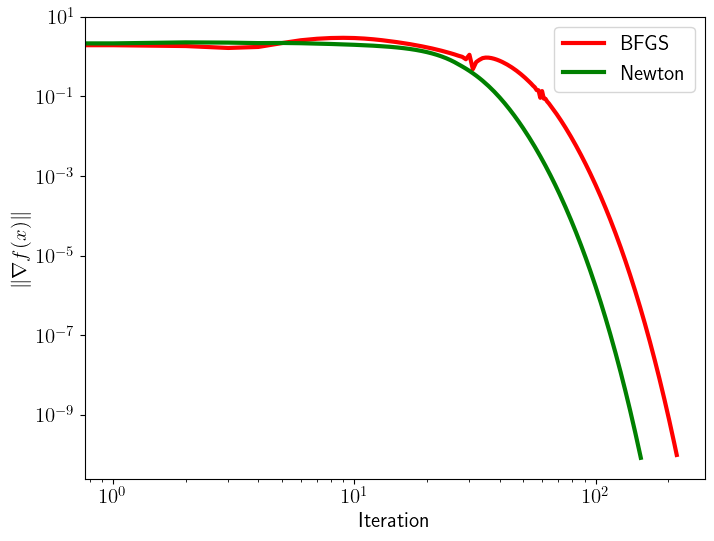

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches((8, 6))

xopt_bfgs, xs_bfgs = bfgs(rosenbrock, jnp.array([0.,0.]), zoom_method='armijo', max_iter = 1000, tol=1e-10)
xopt_newton, xs_newton = newton(rosenbrock, jnp.array([0.,0.]),max_iter = 1000, tol=1e-10)
# xopt_lbfgs, xs_lbfgs = lbfgs(rosenbrock, jnp.array([0.,0.]), tol=1e-10)
# xopt_gd, xs_gd = gradient_descent(rosenbrock, jnp.array([0.,0.]), tol=1e-10)
print('BFGS: ', xopt_bfgs)
print('Newton: ', xopt_newton)
# print('LBFGS: ', xopt_lbfgs)
# print('GD: ', xopt_gd)

x = jnp.linspace(-1., 3, 400)
x1, x2 = jnp.meshgrid(x, x)
z = jax.vmap(rosenbrock)(jnp.stack([x1.flatten(), x2.flatten()], axis=1)).reshape(x1.shape)

cf = ax.contour(x2,x1,z.T, cmap='coolwarm',levels=jnp.max(z)*jnp.linspace(0, 1.0, 40)**2)
ax.clabel(cf, fontsize=12)

z_bfgs= jax.vmap(rosenbrock)(xs_bfgs)# Evaluate Rosenbrock at xs
z_newton= jax.vmap(rosenbrock)(xs_newton)# Evaluate Rosenbrock at xs
# z_lbfgs= jax.vmap(rosenbrock)(xs_lbfgs)# Evaluate Rosenbrock at xs
# z_gd= jax.vmap(rosenbrock)(xs_gd)# Evaluate Rosenbrock at xs
# ax.plot(xs_gd[:,0],xs_gd[:,1],'x-',alpha=1.,color='blue',label='GD')
# ax.plot(xs_lbfgs[:,0],xs_lbfgs[:,1],'x-',alpha=1.,color='orange',label='LBFGS')
ax.plot(xs_bfgs[:,0],xs_bfgs[:,1],'x-',alpha=1.,color='red',label='BFGS')
# ax.plot(xs_newton[:,0],xs_newton[:,1],'x-',alpha=1.,color='green',label='Newton')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
# ax.set_title(r'Rosenbrock function')

ax.legend()
plt.savefig('./figs/rosenbrock_contour.png', dpi =300, bbox_inches='tight')
plt.show()
fig = plt.figure()
fig.set_size_inches((8, 8))
x = jnp.linspace(-1., 1.5, 300)
x1, x2 = jnp.meshgrid(x, x)
z = jax.vmap(rosenbrock)(jnp.stack([x1.flatten(), x2.flatten()], axis=1)).reshape(x1.shape)
# xs = jax.random.uniform(jax.random.PRNGKey(0), (20, 2), minval=-2.0, maxval=2.0)
# ax.plot(xs_gd[:,0],xs_gd[:,1],'x-',alpha=1.,color='blue',label='GD')
# ax.plot(xs_lbfgs[:,0],xs_lbfgs[:,1],'x-',alpha=1.,color='orange',label='LBFGS')

z_bfgs= jax.vmap(rosenbrock)(xs_bfgs)+10.# Evaluate Rosenbrock at xs
z_newton= jax.vmap(rosenbrock)(xs_newton)+10.# Evaluate Rosenbrock at xs

ax = fig.add_subplot(111,projection='3d',computed_zorder=False)
ax.plot(xs_bfgs[:,0],xs_bfgs[:,1],z_bfgs,'x-',alpha=1.,color='red', label='BFGS')
ax.plot(xs_newton[:,0],xs_newton[:,1],z_newton,'x-',alpha=1.,color='green',label='Newton')
ax.plot_surface(x1,x2,z, cmap='coolwarm',edgecolor = 'royalblue',lw=0.5,alpha=0.9,rstride=8,cstride=8)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
# ax.set_title(r'Rosenbrock function')
ax.view_init(20, 100)
ax.legend()
# plt.savefig('./figs/rosenbrock_surface.png', dpi =300, bbox_inches='tight')
plt.show()

grad_f= jax.grad(rosenbrock)
grad_norm_bfgs = jnp.linalg.norm(jax.vmap(grad_f)(xs_bfgs),axis=1)
grad_norm_newton = jnp.linalg.norm(jax.vmap(grad_f)(xs_newton),axis=1)
# grad_norm_lbfgs = jnp.linalg.norm(jax.vmap(grad_f)(xs_lbfgs),axis=1)
# grad_norm_gd = jnp.linalg.norm(jax.vmap(grad_f)(xs_gd),axis=1)
fig= plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(grad_norm_bfgs, label='BFGS', color='red')
ax.plot(grad_norm_newton, label='Newton', color='green')
# ax.plot(grad_norm_lbfgs, label='LBFGS', color='orange')
# ax.plot(grad_norm_gd, label='GD', color='blue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\|\nabla f(x)\|$')
# ax.set_title(r'Convergence of Gradient Norm')
ax.legend()
# plt.savefig('./figs/rosenbrock_grad_norm_convergence.png', dpi =300, bbox_inches='tight')
plt.show()

### Griewank Function
$$
f_{Griewank}(x_1,x_2) = 
\sum_{i=1}^2 \frac{x_i^2}{4000}-\prod_{i=1}^2 \cos \left(\frac{x_i}{\sqrt{i}}\right)+1
$$


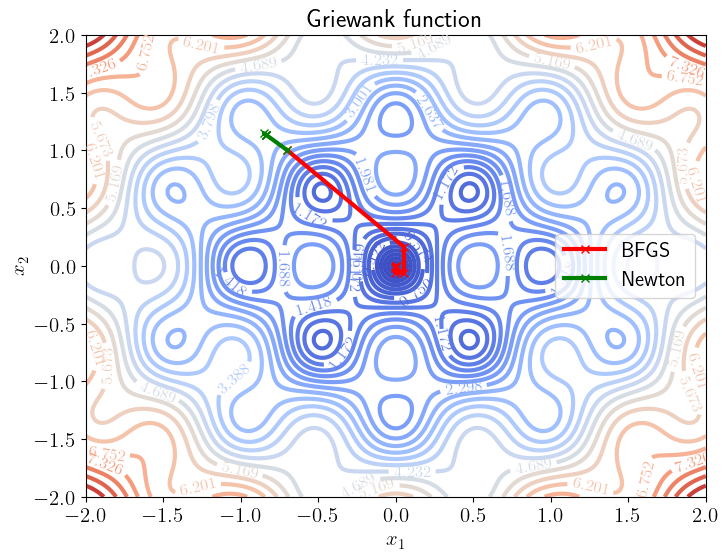

BFGS: [-2.85601494e-07 -2.54940346e-06]
Newton: [-0.84040903  1.13334606]


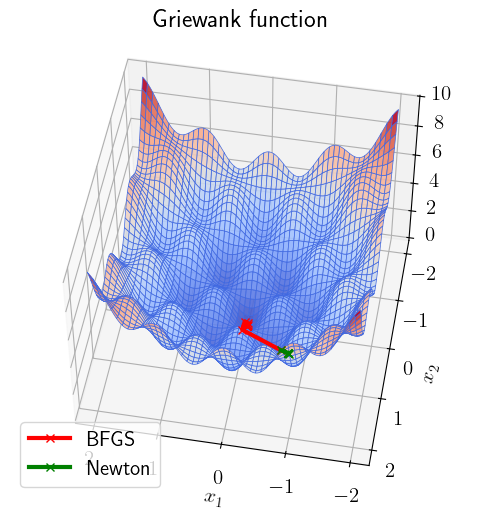

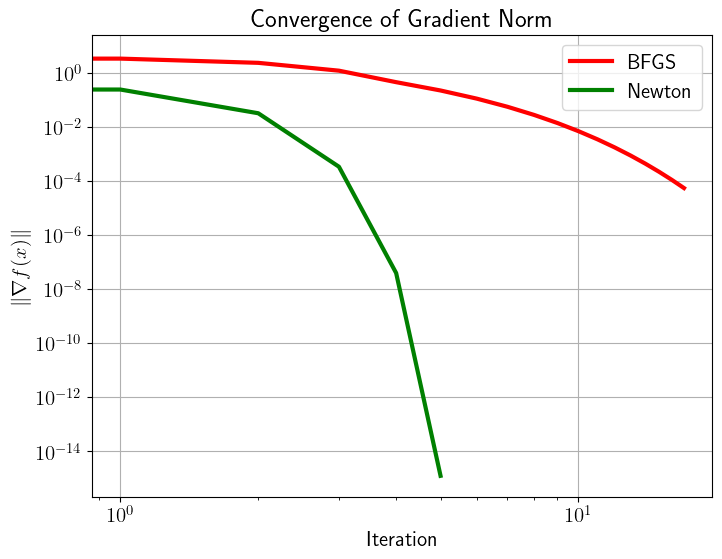

In [8]:
x0 = jnp.array([-.7,1.])
xopt_bfgs, xs_bfgs = bfgs(f5, x0, tol=1e-10)
xopt_newton, xs_newton = newton(f5, x0, tol=1e-10)
# xopt_lbfgs, xs_lbfgs = lbfgs(f5, x0, tol=1e-10)
# xopt_gd, xs_gd = gradient_descent(f5, x0, tol=1e-10)
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches((8, 6))

x = jnp.linspace(-2., 2, 400)
x1, x2 = jnp.meshgrid(x, x)
z = jax.vmap(f5)(jnp.stack([x1.flatten(), x2.flatten()], axis=1)).reshape(x1.shape)

cf = ax.contour(x2,x1,z.T, cmap='coolwarm',levels=jnp.max(z)*jnp.linspace(0, 1.0, 30)**2)
ax.clabel(cf, fontsize=12)

ax.plot(xs_bfgs[:,0],xs_bfgs[:,1],'x-',alpha=1.,color='red', label='BFGS')
ax.plot(xs_newton[:,0],xs_newton[:,1],'x-',alpha=1.,color='green', label='Newton')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title(r'Griewank function')
ax.legend()
plt.show()

fig = plt.figure()
fig.set_size_inches((8, 6))
z = jax.vmap(f5)(jnp.stack([x1.flatten(), x2.flatten()], axis=1)).reshape(x1.shape)

# xs = jax.random.uniform(jax.random.PRNGKey(0), (20, 2), minval=-2.0, maxval=2.0)


z_bfgs= jax.vmap(f5)(xs_bfgs)
z_newton=jax.vmap(f5)(xs_newton)
ax = fig.add_subplot(111,projection='3d',computed_zorder=False)
ax.plot(xs_bfgs[:,0],xs_bfgs[:,1],z_bfgs,'x-',alpha=1.,color='red',label='BFGS')
ax.plot(xs_newton[:,0],xs_newton[:,1],z_newton,'x-',alpha=1.,color='green',label='Newton')
ax.plot_surface(x1,x2,z, cmap='coolwarm',edgecolor = 'royalblue',lw=0.5,alpha=0.9,rstride=8,cstride=8)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title(r'Griewank function')
ax.view_init(50, 100)
print('BFGS:',xopt_bfgs)
print('Newton:',xopt_newton)
ax.legend()
plt.show()

grad_f= jax.grad(f5)
grad_norm_bfgs = jnp.linalg.norm(jax.vmap(grad_f)(xs_bfgs),axis=1)
grad_norm_newton = jnp.linalg.norm(jax.vmap(grad_f)(xs_newton),axis=1)
# grad_norm_lbfgs = jnp.linalg.norm(jax.vmap(grad_f)(xs_lbfgs),axis=1)
# grad_norm_gd = jnp.linalg.norm(jax.vmap(grad_f)(xs_gd),axis=1)
fig= plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(grad_norm_bfgs, label='BFGS', color='red')
ax.plot(grad_norm_newton, label='Newton', color='green')
# ax.plot(grad_norm_lbfgs, label='LBFGS', color='orange')
# ax.plot(grad_norm_gd, label='GD', color='blue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\|\nabla f(x)\|$')
ax.set_title(r'Convergence of Gradient Norm')
ax.grid()
ax.legend()
# plt.savefig('./figs/griewank_grad_norm_convergence.png', dpi =300, bbox_inches='tight')
plt.show()


In [9]:
i=0
def test_function(x):
    global i
    i=i+1
    return f5(x)
xopt, xs = bfgs(test_function, jnp.array([-1.,.7]), tol=1e-10)
print("Number of function evaluations BFGS: ", i)
i=0
xopt, xs = newton(test_function, jnp.array([-1.,.7]), tol=1e-10)
print("Number of function evaluations Newton: ", i)
i=0
xopt, xs = gradient_descent(test_function, jnp.array([-1.,.7]), tol=1e-10)
print("Number of function evaluations Gradient Descent: ", i)



Number of function evaluations BFGS:  132
Number of function evaluations Newton:  25
Max iterations reached
Number of function evaluations Gradient Descent:  1001


In [10]:
fs = [f1,f2,f3, f4, f5,f6, f7,f8,f9,f10]
key = jr.PRNGKey(0)
x0s = [
    jnp.array([-0.1,.5]), # Adjiman
    jr.uniform(key, (100,), minval=-3.0, maxval=3.0), # Rosenbrock N-D
    jr.uniform(key, (10,), minval=8.0, maxval=10.0), # Paviani
    jr.uniform(key, (10,), minval=-0.5, maxval=.5), # Csendes
    jnp.array([-0.7,1.]), # Griewank
   jr.uniform(key, (2,), minval=1.0,maxval=5.),#Hosaki
    jr.uniform(key, (2,), minval=-1.0,maxval=1.), #Brent
    jr.uniform(key, (2,), minval=.0,maxval=1.), #  Giunta
    jr.uniform(key, (2,), minval=-4.0,maxval=-1.), # Styblinski-Tang
    jr.uniform(key, (6,), minval=-6.0,maxval=6.),
]
names = [
    "Adjiman Function",
    "Rosenbrock N-D",
    "Paviani Function",
    "Csendes Function",
    "Griewank Function",
    "Hosaki Function",
    "Brent Function",
    "Giunta Function",
    "Styblinski-Tang Function",
    "Trid 6 Function",
]
tstr = ""
tstr += f"Function | BFGS | Newton | LBFGS | GD\n"
tstr += f"---|---|---|---|---|\n"
tstr2 = ""
tstr2 += f"Function | BFGS | Newton | LBFGS | GD\n"
tstr2 += f"---|---|---|---|---|\n"
tstr3 = ""
tstr3 += f"Function | BFGS | Newton | LBFGS | GD\n"
tstr3 += f"---|---|---|---|---|\n"
tstr4 = ""
tstr4 += f"Function | BFGS | Newton | LBFGS | GD\n"
tstr4 += f"---|---|---|---|---|\n"
k=0
for i in range(len(fs)):
# for i in range(1):
    def f(x):
        global k
        k = k + 1
        return fs[i](x)
    x0 = x0s[i]
    print(f"Function {i+1}: {names[i]}")
    time_bfgs = 0
    time_newton = 0
    time_lbfgs = 0
    time_gd = 0
    fun_evals_bfgs = 0
    fun_evals_newton = 0
    fun_evals_lbfgs = 0
    fun_evals_gd = 0

    start = time.time()
    xopt_bfgs, xs_bfgs = bfgs(f, x0,zoom_method="armijo", max_iter =1000, tol=1e-10)
    time_bfgs = time.time() - start
    fun_evals_bfgs = k   
    k=0
    start = time.time()
    xopt_newton, xs_newton = newton(f, x0 ,max_iter = 1000, tol=1e-10)
    time_newton = time.time() - start
    fun_evals_newton = k
    k=0
    grad_f = jax.grad(f)
    tstr += f"{names[i]}({x0.shape[0]} - D) | {jnp.linalg.norm(grad_f(xopt_bfgs)):.2e} | {jnp.linalg.norm(grad_f(xopt_newton)):.2e}|\n "
    tstr2 += f"{names[i]}({x0.shape[0]} - D) | {time_bfgs/xs_bfgs.shape[0]:.4} | {time_newton/xs_newton.shape[0]:.4}|\n" 
    tstr3 += f"{names[i]}({x0.shape[0]} - D) | {fun_evals_bfgs} | {fun_evals_newton}| \n"
    tstr4 += f"{names[i]}({x0.shape[0]} - D) | {xs_bfgs.shape[0] if not jnp.isnan(jnp.linalg.norm(grad_f(xopt_bfgs))) and jnp.linalg.norm(grad_f(xopt_bfgs)) <1e-6 else 'Did not converge'} | {xs_newton.shape[0] if not jnp.isnan(jnp.linalg.norm(grad_f(xopt_newton))) and jnp.linalg.norm(grad_f(xopt_newton)) <1e-6 else 'Did not converge'}| \n"
    # tstr += f"---|---|---|---|---|\n"
    # print(f(xopt_bfgs),f(xopt_newton),f(xopt_lbfgs),f(xopt_gd))
display(Markdown('#### Table 1: Gradient Norms'))
display(Markdown(tstr))
display(Markdown('#### Table 2: Time per iteration'))
display(Markdown(tstr2))
display(Markdown('#### Table 3: Number of Function evaluations'))
display(Markdown(tstr3))
display(Markdown('#### Table 4: Number of iterations'))
display(Markdown(tstr4))


Function 1: Adjiman Function
Function 2: Rosenbrock N-D
Function 3: Paviani Function
Function 4: Csendes Function
Max iterations reached
Function 5: Griewank Function
Function 6: Hosaki Function
Function 7: Brent Function
Function 8: Giunta Function
Function 9: Styblinski-Tang Function
Function 10: Trid 6 Function
Max iterations reached


#### Table 1: Gradient Norms

Function | BFGS | Newton | LBFGS | GD
---|---|---|---|---|
Adjiman Function(2 - D) | 1.66e-13 | 3.72e-16|
 Rosenbrock N-D(100 - D) | 9.28e-11 | 8.52e-11|
 Paviani Function(10 - D) | nan | nan|
 Csendes Function(10 - D) | 9.41e-11 | 1.21e-03|
 Griewank Function(2 - D) | nan | 1.26e-15|
 Hosaki Function(2 - D) | nan | 8.83e-11|
 Brent Function(2 - D) | 9.00e-11 | 9.46e-11|
 Giunta Function(2 - D) | 2.22e-15 | 1.57e-16|
 Styblinski-Tang Function(2 - D) | 2.93e-14 | 0.00e+00|
 Trid 6 Function(6 - D) | nan | 7.60e-07|
 

#### Table 2: Time per iteration

Function | BFGS | Newton | LBFGS | GD
---|---|---|---|---|
Adjiman Function(2 - D) | 0.01513 | 0.02955|
Rosenbrock N-D(100 - D) | 0.01591 | 0.02724|
Paviani Function(10 - D) | 0.4787 | 0.4113|
Csendes Function(10 - D) | 0.007963 | 0.07097|
Griewank Function(2 - D) | 0.01232 | 0.01462|
Hosaki Function(2 - D) | 0.02848 | 0.05288|
Brent Function(2 - D) | 0.01768 | 0.03674|
Giunta Function(2 - D) | 0.01714 | 0.02852|
Styblinski-Tang Function(2 - D) | 0.01323 | 0.02297|
Trid 6 Function(6 - D) | 0.01646 | 0.05928|


#### Table 3: Number of Function evaluations

Function | BFGS | Newton | LBFGS | GD
---|---|---|---|---|
Adjiman Function(2 - D) | 2737 | 956| 
Rosenbrock N-D(100 - D) | 3745 | 2465| 
Paviani Function(10 - D) | 13 | 7| 
Csendes Function(10 - D) | 5724 | 169638| 
Griewank Function(2 - D) | 1234 | 31| 
Hosaki Function(2 - D) | 1352 | 2060| 
Brent Function(2 - D) | 1789 | 2021| 
Giunta Function(2 - D) | 1218 | 1348| 
Styblinski-Tang Function(2 - D) | 1119 | 1220| 
Trid 6 Function(6 - D) | 1096 | 89229| 


#### Table 4: Number of iterations

Function | BFGS | Newton | LBFGS | GD
---|---|---|---|---|
Adjiman Function(2 - D) | 276 | 72| 
Rosenbrock N-D(100 - D) | 333 | 177| 
Paviani Function(10 - D) | Did not converge | Did not converge| 
Csendes Function(10 - D) | 597 | Did not converge| 
Griewank Function(2 - D) | Did not converge | 6| 
Hosaki Function(2 - D) | Did not converge | 148| 
Brent Function(2 - D) | 199 | 145| 
Giunta Function(2 - D) | 135 | 97| 
Styblinski-Tang Function(2 - D) | 124 | 90| 
Trid 6 Function(6 - D) | Did not converge | 1001| 
